In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import getFamaFrenchFactors as gff
from sklearn.linear_model import Ridge, Lasso
sns.set()

## Download the data

In [10]:
ticker = 'AAPL'
start = '2001-01-01'
end = '2022-10-12'

stock_data = yf.download(ticker, start, end)

stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = 'Month_Rtn'
stock_returns.index = pd.to_datetime(stock_returns.index).date
stock_returns

[*********************100%***********************]  1 of 1 completed
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_69176/3887865971.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()


2001-02-28   -0.156069
2001-03-31    0.209314
2001-04-30    0.154963
2001-05-31   -0.217341
2001-06-30    0.165416
                ...   
2022-06-30   -0.081430
2022-07-31    0.188634
2022-08-31   -0.031208
2022-09-30   -0.120977
2022-10-31    0.005644
Name: Month_Rtn, Length: 261, dtype: float64

## FF3 Factors

In [11]:
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = pd.to_datetime(ff3_monthly.index).date

ff_data = pd.concat([ff3_monthly, stock_returns], axis=1, join='inner')
ff_data

,Mkt-RF,SMB,HML,RF,Month_Rtn
2001-02-28,-0.1005,-0.0078,0.1247,0.0038,-0.156069
2001-03-31,-0.0726,0.0025,0.0642,0.0042,0.209314
2001-04-30,0.0794,0.0055,-0.0467,0.0039,0.154963
2001-05-31,0.0072,0.0250,0.0336,0.0032,-0.217341
2001-06-30,-0.0194,0.0624,-0.0112,0.0028,0.165416
...,...,...,...,...,...
2022-06-30,-0.0844,0.0218,-0.0610,0.0006,-0.081430
2022-07-31,0.0957,0.0280,-0.0403,0.0008,0.188634
2022-08-31,-0.0377,0.0140,0.0029,0.0019,-0.031208
2022-09-30,-0.0935,-0.0082,0.0002,0.0019,-0.120977


In [12]:
ff_data.columns = ['beta', 'size', 'value', 'rf', 'ret']
ff_data

,beta,size,value,rf,ret
2001-02-28,-0.1005,-0.0078,0.1247,0.0038,-0.156069
2001-03-31,-0.0726,0.0025,0.0642,0.0042,0.209314
2001-04-30,0.0794,0.0055,-0.0467,0.0039,0.154963
2001-05-31,0.0072,0.0250,0.0336,0.0032,-0.217341
2001-06-30,-0.0194,0.0624,-0.0112,0.0028,0.165416
...,...,...,...,...,...
2022-06-30,-0.0844,0.0218,-0.0610,0.0006,-0.081430
2022-07-31,0.0957,0.0280,-0.0403,0.0008,0.188634
2022-08-31,-0.0377,0.0140,0.0029,0.0019,-0.031208
2022-09-30,-0.0935,-0.0082,0.0002,0.0019,-0.120977


## Ridge & Lasso

In [13]:
X = ff_data[['beta', 'size', 'value']]
y = ff_data['ret'] - ff_data['rf']

# Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X,y)
print(ridge.coef_, ridge.intercept_)

# Lasso
lasso = Lasso(alpha=0.001)
lasso.fit(X, y)
print(lasso.coef_, lasso.intercept_)

[ 1.01804208  0.08091643 -0.42642725] 0.021775685435580675
[ 0.72247701  0.         -0.        ] 0.02314838423101795


In [14]:
# diff alpha for Ridge
ridge_coef_list = []

alpha_arr = np.linspace(0.0, 4.0, 100)

for alpha in alpha_arr:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    ridge_coef_list.append(ridge.coef_)

            Market      Size     Value
0.000000  1.221239  0.025150 -0.604884
0.040404  1.128549  0.058226 -0.518089
0.080808  1.050895  0.075693 -0.452341
0.121212  0.984249  0.085164 -0.400917
0.161616  0.926128  0.090166 -0.359660
...            ...       ...       ...
3.838384  0.149359  0.024888 -0.032644
3.878788  0.147998  0.024671 -0.032318
3.919192  0.146662  0.024457 -0.031998
3.959596  0.145350  0.024246 -0.031684
4.000000  0.144062  0.024040 -0.031376

[100 rows x 3 columns]


Text(0, 0.5, 'Coefficient')

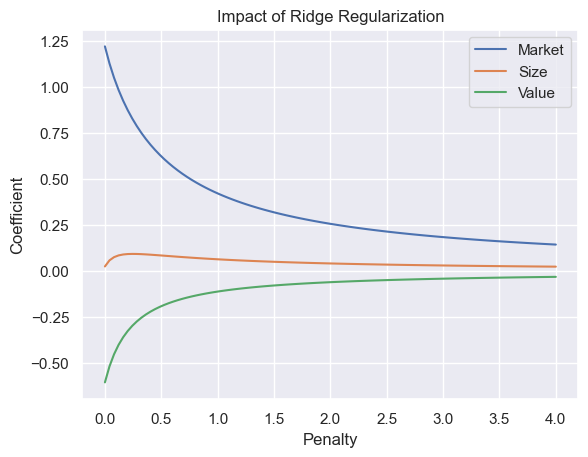

In [16]:
ridge_df = pd.DataFrame(ridge_coef_list, index=alpha_arr, columns=['Market', 'Size', 'Value'])
print(ridge_df)

ridge_df.plot()
plt.title('Impact of Ridge Regularization')
plt.xlabel('Penalty')
plt.ylabel('Coefficient')

In [17]:
# diff alpha for lasso
lasso_coef_list = []

alpha_arr = np.linspace(0.000, 0.010, 100)

for alpha in alpha_arr:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    lasso_coef_list.append(lasso.coef_)

/Users/chulwonchae/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/chulwonchae/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/chulwonchae/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.652e-01, tolerance: 2.614e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impleme

            Market     Size     Value
0.000000  1.221239  0.02515 -0.604884
0.000101  1.172787  0.00000 -0.499801
0.000202  1.120069  0.00000 -0.395069
0.000303  1.067352  0.00000 -0.290336
0.000404  1.014634  0.00000 -0.185604
...            ...      ...       ...
0.009596  0.000000  0.00000 -0.000000
0.009697  0.000000  0.00000 -0.000000
0.009798  0.000000  0.00000 -0.000000
0.009899  0.000000  0.00000 -0.000000
0.010000  0.000000  0.00000 -0.000000

[100 rows x 3 columns]


Text(0, 0.5, 'Coefficient')

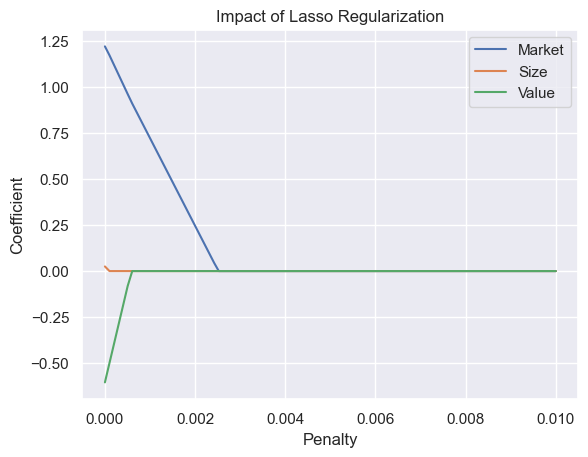

In [18]:
lasso_df = pd.DataFrame(lasso_coef_list, index=alpha_arr, columns=['Market', 'Size', 'Value'])
print(lasso_df)

lasso_df.plot()
plt.title('Impact of Lasso Regularization')
plt.xlabel('Penalty')
plt.ylabel('Coefficient')

In [19]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

X = ff_data[['beta', 'size', 'value']]
y = ff_data['ret'] - ff_data['rf']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)

In [20]:
# Bound of Alpha
alpha_values = {'alpha': np.logspace(-4, 4, 50)}
ridge = Ridge()

# GridSearch with Cross validation
grid_search = GridSearchCV(ridge, alpha_values, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"Optimal alpha: {best_alpha}")


Optimal alpha: 0.013257113655901081


In [21]:
# 최적의 알파 값으로 Ridge 회귀 모델 학습
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

y_pred = ridge_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")


Mean Squared Error on Test Set: 0.006099069731571592
